In [1]:
import numpy as np # type: ignore
import bispy as bsp # type: ignore
import quaternion as qt # type: ignore
import scipy # type: ignore

import matplotlib.pyplot as plt # type: ignore
from matplotlib.colors import LightSource # type: ignore

from sonata_base import *
from sonata_ellipse import *
from sonata_slra import *
from sonata_visuals import *

%reload_ext autoreload
%autoreload 2

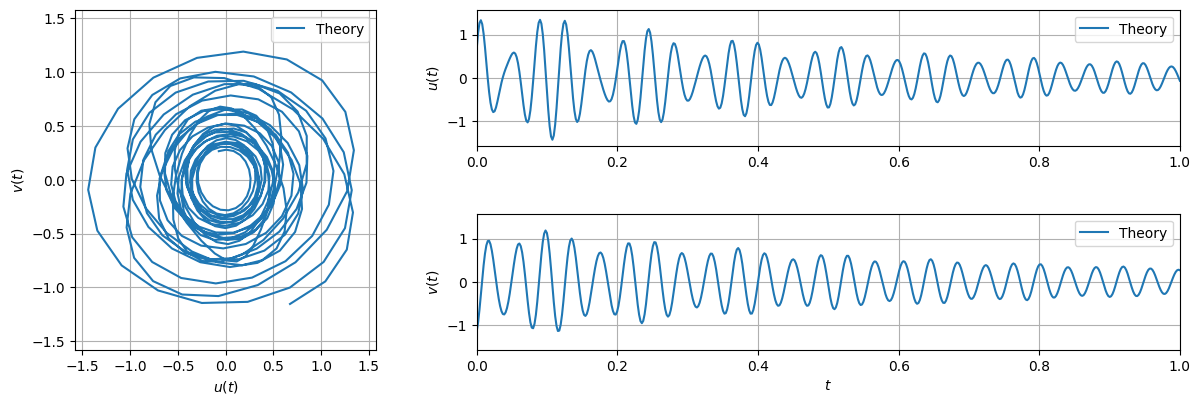

In [2]:
N = 512 # Number of samples
t = np.linspace(0,1,N) # time stamps

R = 2

y, M, q = generate_ellipse_mixture(N,R)
plot_theoretical_signal(t,y)

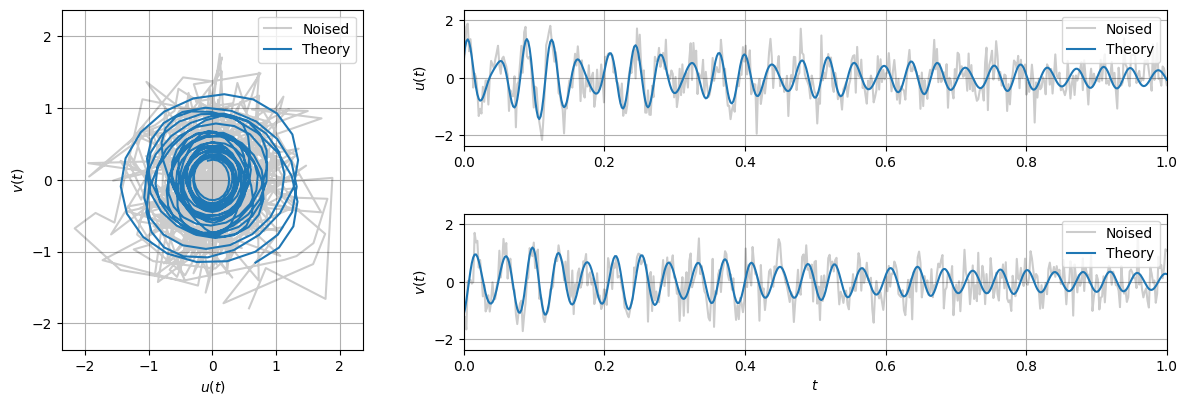

In [3]:
snr = 1

y_noised, b = add_quaternion_white_noise(y,snr)

plot_noisy_signal(t,y,b, method_limits='noise')

In [4]:
L = 256

H = signal_to_hankel(y_noised,L)

U,D,Vh = SVDH(H,R = R)

M_0 = np.zeros([N,R],dtype = complex)
q_0 = np.zeros(R,dtype = qt.quaternion)

for r in range(R):
    y_r = hankel_to_signal(D[r]*ldot(np.reshape(U[:,r],[-1,1]),np.reshape(Vh[r,:],[1,-1])))
    a, theta, chi, phi = bsp.utils.quat2euler(y_r)
    
    theta_0 = np.mean(theta)
    chi_0 = np.mean(chi)
    phi_0 = phi[0]
    a_0 = a[0]
    
    q_0[r] = bsp.utils.euler2quat(a_0,theta_0,chi_0,phi_0)
    M_0[:,r] = a*np.exp((phi-phi_0)*1j)/a_0

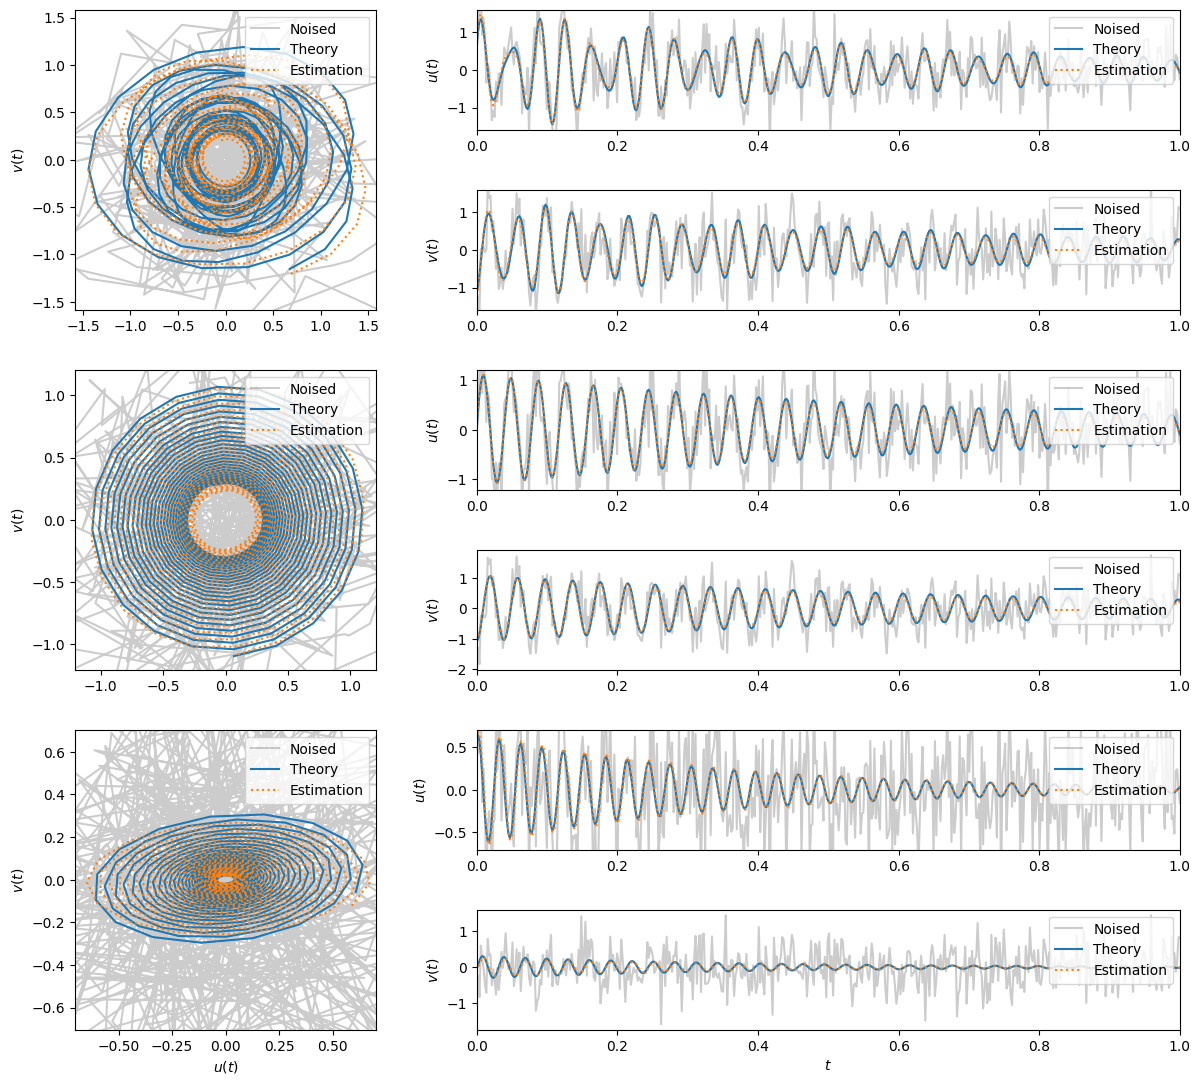

In [5]:
M_hat_svd, q_hat_svd, flagOuter = sonata(y_noised,R,number_inner_iterations=5, number_outer_iterations=50,M_0 = M_0)

plot_estimated_ellipses(t,M,M_hat_svd,q,q_hat_svd,y_noised,method_limits='theory')

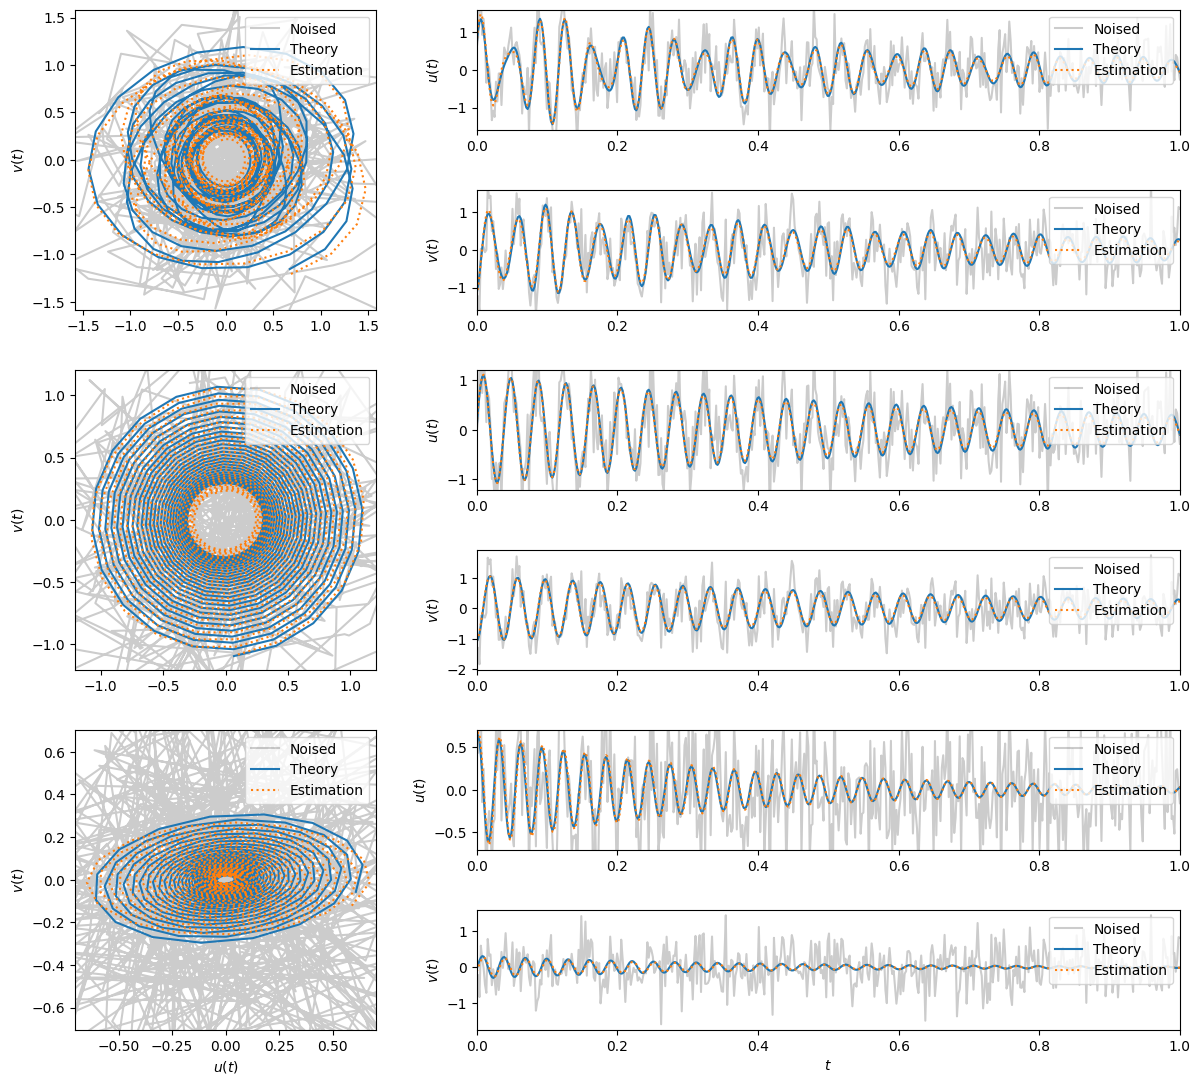

In [6]:
M_hat_rng, q_hat_rng, flag_outer = sonata(y_noised,R,number_inner_iterations=5, number_outer_iterations=50)

plot_estimated_ellipses(t,M,M_hat_rng,q,q_hat_rng,y_noised,method_limits='theory')

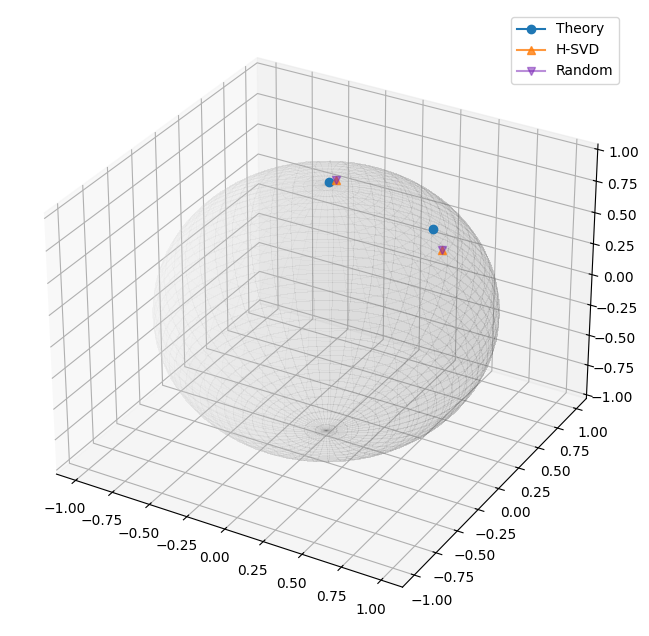

In [7]:
color_th = "#1f77b4"
color_hat_rng = "#771fb4"
color_hat_svd = "#ff7f0e"

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d', computed_zorder=False)

u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)

r = 0.99
ls = LightSource(azdeg=210, altdeg=30)
ax.plot_surface(r*x, r*y, r*z, color=(0.9, 0.9, 0.9), alpha=.1, zorder=-1, rstride=1, cstride=1, \
                linewidth=0, antialiased=False)

for r in range(R):
    a, theta, chi = bsp.utils.quat2euler(q[r])[:3]
    S0,S1,S2,S3 = bsp.utils.geo2Stokes(a,theta,chi)
    s1, s2, s3 = bsp.utils.normalizeStokes(S0,S1,S2,S3)
    p, = ax.plot(s1,s2,s3,marker = 'o', color = color_th)
    
    a_hat, theta_hat, chi_hat = bsp.utils.quat2euler(q_hat_svd[r])[:3]
    S0_hat,S1_hat,S2_hat,S3_hat = bsp.utils.geo2Stokes(a_hat,theta_hat,chi_hat)
    s1_hat, s2_hat, s3_hat = bsp.utils.normalizeStokes(S0_hat,S1_hat,S2_hat,S3_hat)
    p_hat_svd, = ax.plot(s1_hat,s2_hat,s3_hat,marker = '^', color = color_hat_svd,alpha = 0.8)

    a_rng, theta_rng, chi_rng = bsp.utils.quat2euler(q_hat_rng[r])[:3]
    S0_rng,S1_rng,S2_rng,S3_rng = bsp.utils.geo2Stokes(a_rng,theta_rng,chi_rng)
    s1_rng, s2_rng, s3_rng = bsp.utils.normalizeStokes(S0_rng,S1_rng,S2_rng,S3_rng)
    p_hat_rng, = ax.plot(s1_rng,s2_rng,s3_rng,marker = 'v', color = color_hat_rng,alpha = 0.5)

ax.legend([p, p_hat_svd, p_hat_rng], ["Theory", "H-SVD", "Random"])
    
plt.show()

In [8]:
print(np.mean(abs(q_hat_svd-q_hat_rng)**2))

1.4388110367298015e-11
